# Comparison of mQTL detected per ancestry

In [1]:
library(tidyverse)
library(scales)
library(data.table)
library(VennDiagram)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

Warning message:
“package ‘tibble’ was built under R version 4.1.1”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: grid

Loading required package: futile.logger



## Loading and processing data
First tried filtering to FDR < 0.05, comparing hits, then moving on to effect sizes

In [2]:
grafpop_groups <- list(
    "EUR" = "/scratch/st-dennisjk-1/wcasazza/delahaye_QC/matrix_eqtl_data/cis_mQTL_EUR_FDR.txt",
    "AFR_AM" = "/scratch/st-dennisjk-1/wcasazza/delahaye_QC/matrix_eqtl_data/cis_mQTL_AFR_AM_FDR.txt",
    "LAT_AM" = "/scratch/st-dennisjk-1/wcasazza/delahaye_QC/matrix_eqtl_data/cis_mQTL_LAT_AM_FDR.txt",
    "LAT_AM_1" = "/scratch/st-dennisjk-1/wcasazza/delahaye_QC/matrix_eqtl_data/cis_mQTL_LAT_AM_2_FDR.txt",
    "LAT_AM_2" = "/scratch/st-dennisjk-1/wcasazza/delahaye_QC/matrix_eqtl_data/cis_mQTL_LAT_AM_1_FDR.txt"
)
QTL_data <- rbindlist(lapply(grafpop_groups,fread),idcol = "ancestry")
colnames(QTL_data)[2:7] <- c("SNP", "probe","b","t","p","FDR") 
n_tested <- 335866242

In [3]:
QTL_data[,.(cpg=uniqueN(probe[FDR < 0.05]), bonf = uniqueN(probe[p < 0.05/n_tested])), by="ancestry"]

ancestry cpg    bonf 
1 EUR       54071  8748
2 AFR_AM   126612 19268
3 LAT_AM    81261 12158
4 LAT_AM_1  18462  2732
5 LAT_AM_2  10425  1430

## Overlap in hits
Direct replication and $\pi_1$

In [10]:
EUR <- QTL_data[ancestry == "EUR"]
AFR_AM <- QTL_data[ancestry == "AFR_AM"]
LAT_AM <- QTL_data[ancestry == "LAT_AM"]
# EUR vs. AFR_AM
sum(unique(EUR[p < 0.05 / n_tested]$probe )%in% unique(AFR_AM[p < 0.05 / n_tested]$probe))
shared_AFR_AM <- AFR_AM[EUR[FDR < 0.05,.(SNP,probe)],on=c("SNP","probe"),nomatch=0]$p
1 - qvalue::pi0est(shared_AFR_AM / max(shared_AFR_AM))$pi0

# EUR vs. LAT_AM
sum(unique(EUR[p < 0.05 / n_tested]$probe) %in% unique(LAT_AM[p < 0.05 / n_tested]$probe))
shared_LAT_AM <- LAT_AM[EUR[FDR < 0.05,.(SNP,probe)],on=c("SNP","probe"),nomatch=0]$p
1 - qvalue::pi0est(shared_LAT_AM / max(shared_LAT_AM))$pi0

#AFR_AM vs. LAT_AM
sum(unique(AFR_AM[p < 0.05 / n_tested]$probe) %in% unique(LAT_AM[p < 0.05 / n_tested]$probe))
shared_AFR_AM_LAT_AM <- AFR_AM[LAT_AM[FDR < 0.05,.(SNP,probe)],on=c("SNP","probe"),nomatch=0]$p
1 - qvalue::pi0est(shared_AFR_AM_LAT_AM / max(shared_AFR_AM_LAT_AM))$pi0

[1] 5656

[1] 0.8865394

[1] 5831

[1] 0.9028643

[1] 7397

[1] 0.9024315

Plotting overlap in a venn diagram:

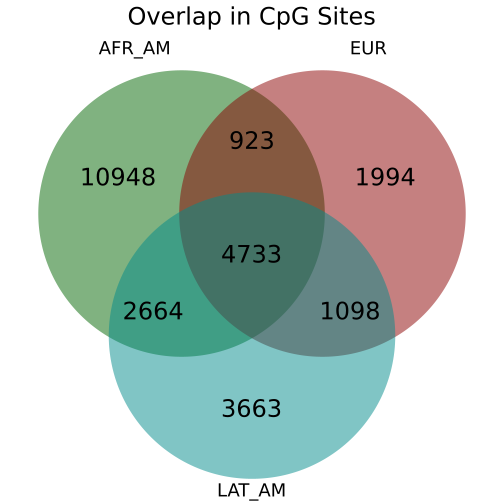

In [15]:
options(repr.plot.width = 7, repr.plot.height = 7,jupyter.plot_mimetypes = "image/svg+xml")

grid.draw(
    venn.diagram(
        list(
            "AFR_AM" = unique(AFR_AM[p < 0.05 / n_tested]$probe),
            "EUR" = unique(EUR[p < 0.05 / n_tested]$probe),
            "LAT_AM" = unique(LAT_AM[p < 0.05 / n_tested]$probe)
        ),
        filename=NULL,
        fill=c("dark green", "dark red", "dark cyan"),
        cat.pos=c(-15,15,180),
        lty = rep("blank",3),
        cex=2,
        cat.cex=1.5,
        main.cex=2,
        fontfamily= rep("sans-serif",1),
        main.fontfamily= rep("sans-serif",3),
        cat.fontfamily= rep("sans-serif",3),
        main = "Overlap in CpG Sites"
    )
)

In [13]:
array_annot < -fread("/scratch/st-dennisjk-1/wcasazza/450k_annotation.csv")

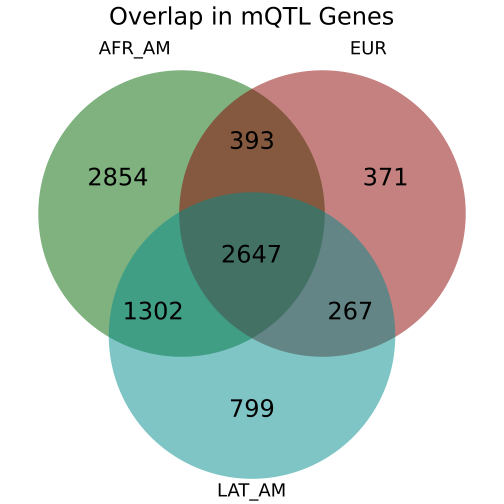

In [16]:
options(repr.plot.width = 7, repr.plot.height = 7,jupyter.plot_mimetypes = "image/svg+xml")
grid.draw(
    venn.diagram(
        list(
            "AFR_AM" = unique(AFR_AM[p < 0.05 / n_tested][array_annot,.(gene=gsub(";.*","",UCSC_RefGene_Name)),on = c("probe"="Name"),nomatch=0]$gene),
            "EUR" = unique(EUR[p < 0.05 / n_tested][array_annot,.(gene=gsub(";.*","",UCSC_RefGene_Name)),on = c("probe"="Name"),nomatch=0]$gene),
            "LAT_AM" = unique(LAT_AM[p < 0.05 / n_tested][array_annot,.(gene=gsub(";.*","",UCSC_RefGene_Name)),on = c("probe"="Name"),nomatch=0]$gene)
        ),
        filename=NULL,
        fill=c("dark green", "dark red", "dark cyan"),
        cat.pos=c(-15,15,180),
        lty = rep("blank",3),
        cex=2,
        cat.cex=1.5,
        main.cex=2,
        fontfamily= rep("sans-serif",1),
        main.fontfamily= rep("sans-serif",3),
        cat.fontfamily= rep("sans-serif",3),
        main = "Overlap in mQTL Genes"
    )
)

## Comparing effect sizes across significant hits per ancestry vs EUR

In [5]:
merged_AFR_AM_EUR <- AFR_AM[p < 0.05 / n_tested][,.SD[which.min(p)],by="probe"][EUR, on=c("SNP","probe"),nomatch=0]
merged_LAT_AM_EUR <- LAT_AM[p < 0.05 / n_tested][,.SD[which.min(p)],by="probe"][EUR, on=c("SNP","probe"),nomatch=0]
merged_AFR_AM_LAT_AM <- AFR_AM[p < 0.05 / n_tested][,.SD[which.min(p)],by="probe"][LAT_AM, on=c("SNP","probe"),nomatch=0]

In [6]:
options(repr.plot.width = 9, repr.plot.height = 7,jupyter.plot_mimetypes = "image/svg+xml")
merged_AFR_AM_EUR$sig <- recode_factor(factor(merged_AFR_AM_EUR$i.p < 0.05 / n_tested),`TRUE`="Significant mQTL in EUR",`FALSE`="Non-significant in EUR")
ggplot(merged_AFR_AM_EUR,aes(scale(t),scale(i.t)))+
    geom_point(aes(shape = sig , color = sig),size=3)+
    stat_smooth(aes(color=sig),linetype="dashed",method="lm",fullrange = TRUE)+
    scale_color_manual(values=c(muted("red"),"gray20")) +
    scale_shape_manual(values=c(16,21))+
    labs(y="Scaled Z-score in EUR", x="Scaled Z-score in AFR_AM",color=NULL,shape=NULL)+
    theme_minimal(base_size=16)

merged_LAT_AM_EUR$sig <- recode_factor(factor(merged_LAT_AM_EUR$i.p < 0.05 / n_tested),`TRUE`="Significant mQTL in EUR",`FALSE`="Non-significant in EUR")
ggplot(merged_LAT_AM_EUR,aes(scale(t),scale(i.t)))+
    geom_point(aes(shape = sig , color = sig),size=3)+
    stat_smooth(aes(color=sig),linetype="dashed",method="lm",fullrange = TRUE)+
    scale_color_manual(values=c(muted("red"),"gray20")) +
    scale_shape_manual(values=c(16,21))+
    labs(y="Scaled Z-score in EUR", x="Scaled Z-score in LAT_AM",color=NULL,shape=NULL)+
    theme_minimal(base_size=16)


merged_AFR_AM_LAT_AM$sig <- recode_factor(factor(merged_AFR_AM_LAT_AM$i.p < 0.05 / n_tested),`TRUE`="Significant mQTL in AFR_AM",`FALSE`="Non-significant in AFR_AM")
ggplot(merged_AFR_AM_LAT_AM,aes(scale(t),scale(i.t)))+
    geom_point(aes(shape = sig , color = sig),size=3)+
    stat_smooth(aes(color=sig),linetype="dashed",method="lm",fullrange = TRUE)+
    scale_color_manual(values=c(muted("red"),"gray20")) +
    scale_shape_manual(values=c(16,21))+
    labs(y="Scaled Z-score in AFR_AM", x="Scaled Z-score in LAT_AM",color=NULL,shape=NULL)+
    theme_minimal(base_size=16)

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



`geom_smooth()` using formula 'y ~ x'



In [7]:
cor.test(merged_AFR_AM_EUR$t,merged_AFR_AM_EUR$i.t, method="spearman")
cor.test(merged_AFR_AM_EUR[sig == "Significant mQTL in EUR"]$t,merged_AFR_AM_EUR[sig == "Significant mQTL in EUR"]$i.t, method="spearman")
cor.test(merged_AFR_AM_EUR[sig == "Non-significant in EUR"]$t,merged_AFR_AM_EUR[sig == "Non-significant in EUR"]$i.t, method="spearman")


	Spearman's rank correlation rho

data:  merged_AFR_AM_EUR$t and merged_AFR_AM_EUR$i.t
S = 7156890904, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.9129709 



	Spearman's rank correlation rho

data:  merged_AFR_AM_EUR[sig == "Significant mQTL in EUR"]$t and merged_AFR_AM_EUR[sig == "Significant mQTL in EUR"]$i.t
S = 1888677390, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
   rho 
0.9045 



	Spearman's rank correlation rho

data:  merged_AFR_AM_EUR[sig == "Non-significant in EUR"]$t and merged_AFR_AM_EUR[sig == "Non-significant in EUR"]$i.t
S = 969883976, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
     rho 
0.781863 


In [8]:
cor.test(merged_LAT_AM_EUR$t,merged_LAT_AM_EUR$i.t, method="spearman")
cor.test(merged_LAT_AM_EUR[sig == "Significant mQTL in EUR"]$t,merged_LAT_AM_EUR[sig == "Significant mQTL in EUR"]$i.t, method="spearman")
cor.test(merged_LAT_AM_EUR[sig == "Non-significant in EUR"]$t,merged_LAT_AM_EUR[sig == "Non-significant in EUR"]$i.t, method="spearman")


	Spearman's rank correlation rho

data:  merged_LAT_AM_EUR$t and merged_LAT_AM_EUR$i.t
S = 4793711210, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
     rho 
0.928297 



	Spearman's rank correlation rho

data:  merged_LAT_AM_EUR[sig == "Significant mQTL in EUR"]$t and merged_LAT_AM_EUR[sig == "Significant mQTL in EUR"]$i.t
S = 1875244350, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.9235623 



	Spearman's rank correlation rho

data:  merged_LAT_AM_EUR[sig == "Non-significant in EUR"]$t and merged_LAT_AM_EUR[sig == "Non-significant in EUR"]$i.t
S = 338749154, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.7789566 


In [9]:
cor.test(merged_AFR_AM_LAT_AM$t,merged_AFR_AM_LAT_AM$i.t, method="spearman")
cor.test(merged_AFR_AM_LAT_AM[sig == "Significant mQTL in AFR_AM"]$t,merged_AFR_AM_LAT_AM[sig == "Significant mQTL in AFR_AM"]$i.t, method="spearman")
cor.test(merged_AFR_AM_LAT_AM[sig == "Non-significant in AFR_AM"]$t,merged_AFR_AM_LAT_AM[sig == "Non-significant in AFR_AM"]$i.t, method="spearman")


	Spearman's rank correlation rho

data:  merged_AFR_AM_LAT_AM$t and merged_AFR_AM_LAT_AM$i.t
S = 1.8413e+10, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.9022089 



	Spearman's rank correlation rho

data:  merged_AFR_AM_LAT_AM[sig == "Significant mQTL in AFR_AM"]$t and merged_AFR_AM_LAT_AM[sig == "Significant mQTL in AFR_AM"]$i.t
S = 4.514e+09, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.8855841 



	Spearman's rank correlation rho

data:  merged_AFR_AM_LAT_AM[sig == "Non-significant in AFR_AM"]$t and merged_AFR_AM_LAT_AM[sig == "Non-significant in AFR_AM"]$i.t
S = 2851858478, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.7737617 
